In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random as ra
import math

from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.patches as mpatches

input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 10 #binary for whether it is digit or not
        
epochs = 10            
batch_size = 1000 #just for loading more data easily
learning_rate = 0.001

train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 128
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #128 - 64
        self.fc2 = nn.Linear(hidden_size1, out_size)       #64 - 10
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight) #only works with ReLU
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    

net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

file_pth = 'binary_ffn_all.pth'
net.load_state_dict(torch.load(file_pth)) #pre-trained



<All keys matched successfully>

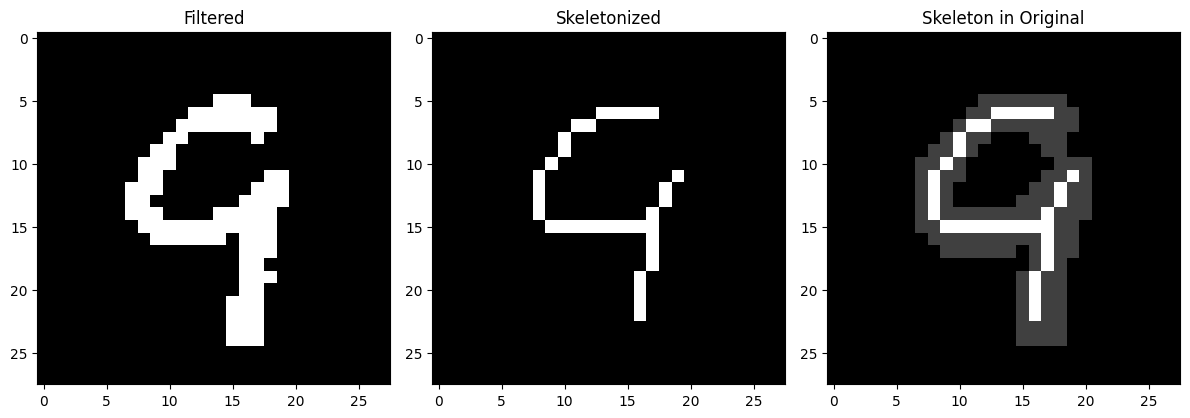

Found 550 concept clusters


/tmp/ipykernel_78933/2802453014.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(img, device=img.device),


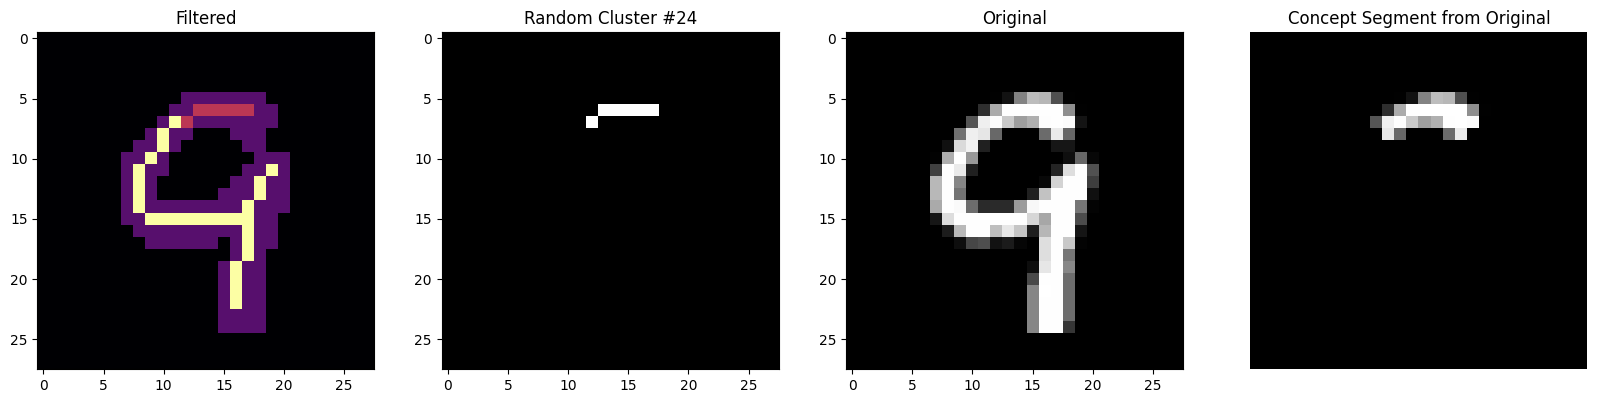

tensor(0.2345, device='cuda:0')


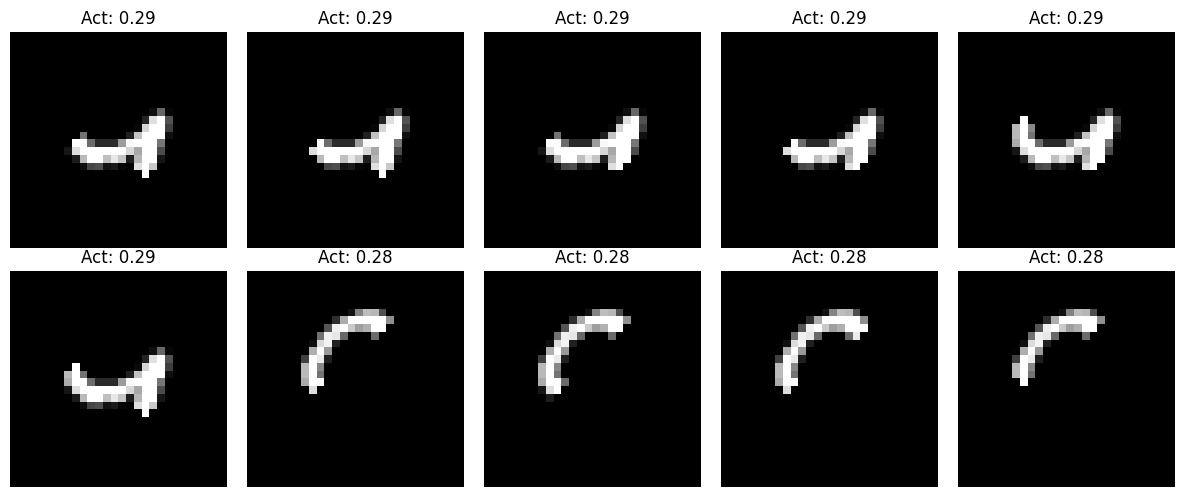

Selected concept indices: [204, 53, 549]


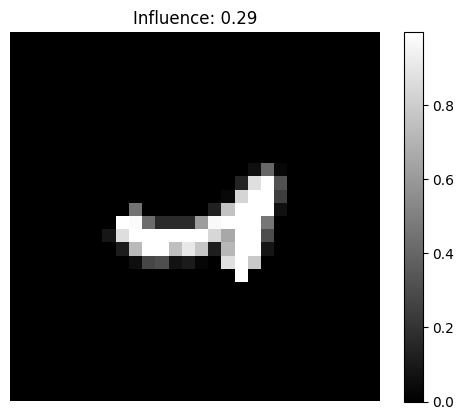

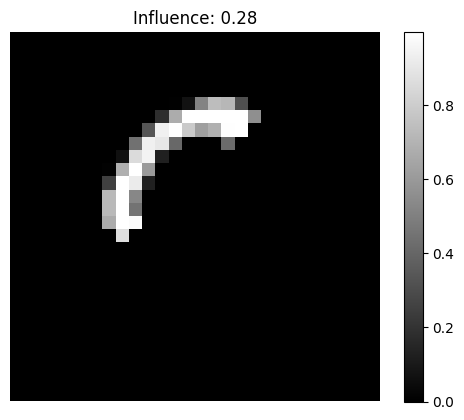

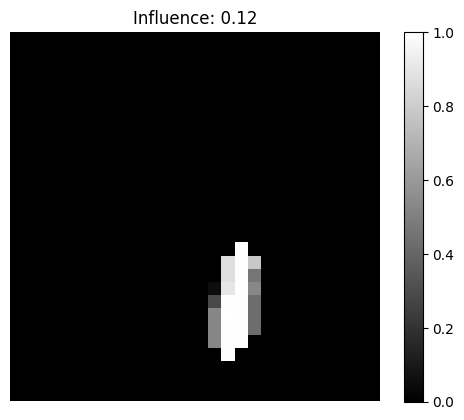

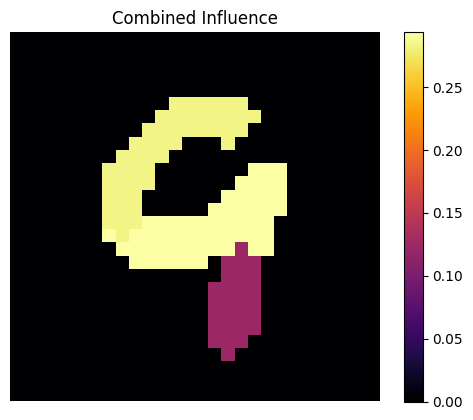

In [6]:
inputs, labels = next(iter(test_loader))

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == 9:
        img = inputs[ind].squeeze()
        break

import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize


"""inputs, labels = next(iter(test_loader))
dig_to_check = ra.randint(0, 9)

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break"""


img_np = img.cpu().numpy()
filtered = img_np > 0.5 #becuase skeleton works on binary 1, 0 data

skeleton = skeletonize(filtered)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Filtered")
plt.imshow(filtered, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Skeletonized")
plt.imshow(skeleton, cmap='gray')

#is this better than the other method??? update: yeah it actually is, screw the other one


actual = torch.where(
    img == 0,
    torch.tensor(0.0, device=img.device),
    0.25
)

y_true, x_true = np.where(skeleton)
for y, x in zip(y_true, x_true):
    actual[y, x] = 1

plt.subplot(1, 3, 3)
plt.title("Skeleton in Original")
plt.imshow(actual, cmap="gray")

plt.tight_layout()
plt.show()


import networkx as nx
from scipy.ndimage import distance_transform_edt

def build_pixel_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape
    for i in range(rows):
        for j in range(cols):
            if skeleton[i, j]:
                G.add_node((i, j))
                for dx in [-1, 0, 1]: #8 neighbors
                    for dy in [-1, 0, 1]:
                        if dx == 0 and dy == 0:
                            continue
                        ni, nj = i + dx, j + dy
                        if 0 <= ni < rows and 0 <= nj < cols and skeleton[ni, nj]:
                            G.add_edge((i, j), (ni, nj))
    return G

def find_clusters(G, min_size=5, max_size=10):
    clusters = []
    seen = set()

    def dfs(node, cluster, visited):
        if len(cluster) > max_size:
            return
        cluster_key = tuple(sorted(cluster))
        if cluster_key not in seen and min_size <= len(cluster) <= max_size:
            seen.add(cluster_key)
            clusters.append(cluster.copy())

        for neighbor in G[node]:
            if neighbor not in visited:
                dfs(neighbor, cluster + [neighbor], visited | {neighbor})

    for node in G.nodes:
        dfs(node, [node], set([node]))

    return clusters

def clusters_to_tensor(clusters, shape=(28, 28)):
    masks = []
    for cluster in clusters:
        mask = np.zeros(shape, dtype=np.uint8)
        for (i, j) in cluster:
            mask[i, j] = 1
        masks.append(mask)
    return torch.tensor(np.stack(masks), dtype=torch.uint8).permute(1, 2, 0)

#clustering
G = build_pixel_graph(skeleton)
clusters = find_clusters(G, min_size=5, max_size=15)
cluster_tensor = clusters_to_tensor(clusters) #[28, 28, n]



#plotting stuff:
print(f"Found {cluster_tensor.shape[2]} concept clusters")

y_true, x_true = np.where(skeleton)
for y, x in zip(y_true, x_true):
    actual[y, x] = 1.0

rand_idx = ra.randint(0, cluster_tensor.shape[2] - 1)
cluster_mask = cluster_tensor[:, :, rand_idx].numpy()
for y, x in np.argwhere(cluster_mask == 1):
    actual[y, x] = 0.5

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.title("Filtered")
plt.imshow(actual, cmap='inferno')

plt.subplot(1, 4, 2)
plt.title(f'Random Cluster #{rand_idx}')
plt.imshow(cluster_tensor[:, :, rand_idx], cmap='gray')

plt.subplot(1, 4, 3)
plt.title('Original')
plt.imshow(img, cmap='gray')

img2 = torch.where(
    img != 0,
    torch.tensor(img, device=img.device),
    0.0
)

inverted_mask = 1 - cluster_mask #cluster mask must be binary for the following methods btw
distance = distance_transform_edt(inverted_mask)
within_range_mask = (distance <= 2).astype(np.float32)
img2 = torch.from_numpy(img_np * within_range_mask) #back to tensor cause I'll give it to the model

plt.subplot(1, 4, 4)
plt.title('Concept Segment from Original')
plt.imshow(img2, cmap='gray')

plt.axis('off')
plt.show()


original_clusters = torch.zeros_like(cluster_tensor)
original_clusters = []

for i in range(cluster_tensor.shape[2]):
    mask = cluster_tensor[:, :, i].numpy()
    inverted_mask = 1 - mask
    distance = distance_transform_edt(inverted_mask)
    within_range_mask = (distance <= 2).astype(np.float32)
    new_input = torch.from_numpy(img_np * within_range_mask).float()
    original_clusters.append(new_input)
    
#plt.imshow(original_clusters[ra.randint(0, cluster_tensor.shape[2])])


#model prep, no eval:

with torch.no_grad():
    activations_this_class = []
    for input_mat in original_clusters:
        if CUDA:
            input_mat = input_mat.cuda()

        a0 = F.tanh(net.fc0(input_mat.float().view(-1)))
        a1 = F.tanh(net.fc1(a0))
        logits = net.fc2(a1)

        prob_distr = torch.sigmoid(logits/5)

        confidence = (1.1 * torch.max(prob_distr) - 0.1 * (torch.sum(prob_distr))) 

        activations_this_class.append(confidence) #torch.max(prob_distr))

        #print(logits)

    """        scalars = [x.item() for x in activations_this_class]
            min_val = min(scalars)
            max_val = max(scalars)
            range_local = max_val - min_val

            for i, act in enumerate(activations_this_class):
                activations_this_class[i] = torch.tanh((max_val-act) / (act-min_val-0.0001) - 1 )    #2 * (act - min_val) / range_local - 1
    """

    print(activations_this_class[0])


#get highest actiations and plot the corresponding img:

activations = torch.tensor([a.item() for a in activations_this_class])
top10_values, top10_indices = torch.topk(activations, 10, largest=True)

top10_tensors = [original_clusters[idx] for idx in top10_indices]

fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()

for i, ax in enumerate(axs):
    im = top10_tensors[i]
    ax.imshow(im.numpy(), cmap='gray')
    ax.set_title(f"Act: {top10_values[i]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()


def get_unique_concepts(original_clusters, activations, overlap_threshold=0.1):
    activations = torch.tensor(activations)
    abs_activations = activations.abs()
    sorted_indices = torch.argsort(abs_activations, descending=True)
    selected_indices = []
    #first_mask = torch.zeros_like(original_clusters[0]).bool()
    #plt.imshow(combined_mask)

    for i, idx in enumerate(sorted_indices):
        concept_mask = original_clusters[idx] != 0

        if i == 0:
            comp_mask = original_clusters[0] != 0
            selected_indices.append(idx.item())

        similarities = []
        for ind in selected_indices:
            comp_mask = original_clusters[ind] != 0
            normaliser = concept_mask.sum().float() if concept_mask.sum().float() < comp_mask.sum().float() else comp_mask.sum().float()
            similarities.append((concept_mask & comp_mask).sum().float() / normaliser)

        similarity = max(similarities) #(concept_mask & comp_mask).sum().float() / concept_mask.sum().float()

        if concept_mask.sum() != 0 and similarity < 0.25:
            comp_mask = concept_mask
            selected_indices.append(idx.item())

    return selected_indices


overlap_threshold = 0.25
selected_indices = get_unique_concepts(original_clusters, activations_this_class, overlap_threshold)
print("Selected concept indices:", selected_indices)

combined = np.zeros_like(original_clusters[0], dtype=float)

for idx in selected_indices:
    mat = original_clusters[idx]
    value = activations_this_class[idx].item()
    title = f"Influence: {round(value, 2)}"

    plt.figure()
    plt.imshow(mat, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.axis('off')
    plt.show()

    combined[mat != 0] = value

plt.figure()
plt.imshow(combined, cmap='inferno')
plt.title("Combined Influence")
plt.colorbar()
plt.axis('off')
plt.show()